In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Load data
data_frame= pd.read_csv('/mnt/disk15tb/paula/Main_DA_Projects/data_analysis_output/Primary Neurons/CDKL5_T2_Jan29/Network_outputs/Compiled_Networks.csv')  # Ensure to change the path as needed
data_frame.columns

Index(['Run_ID', 'DIV', 'Well', 'NeuronType', 'Time', 'Chip_ID', 'mean_IBI',
       'cov_IBI', 'mean_Burst_Peak', 'cov_Burst_Peak', 'Number_Bursts',
       'mean_Spike_per_Burst', 'cov_Spike_per_Burst', 'mean_Burst_Peak_Abs',
       'cov_Burst_Peak_Abs', 'mean_BurstDuration', 'cov_BurstDuration',
       'MeanNetworkISI', 'CoVNetworkISI', 'MeanWithinBurstISI',
       'CoVWithinBurstISI', 'MeanOutsideBurstISI', 'CoVOutsideBurstISI',
       'Fanofactor', 'BurstRate', 'IBI_List', 'Burst_Peak_List',
       'Abs_Burst_Peak_List', 'Burst_Times_List', 'SpikesPerBurst_List'],
      dtype='object')

In [2]:
from itertools import combinations
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

# Columns to process
columns_to_process = ['Burst_Peak_List', 'Burst_Times_List', 'IBI_List', 'SpikesPerBurst_List','Abs_Burst_Peak_List']

# Step 1: Convert the specified columns into individual lists of floats
temp_df = data_frame.copy()
for column in columns_to_process:
    temp_df[column] = temp_df[column].apply(lambda x: [float(i) for i in x.split(",")])

# Truncate lists to match the shortest length for each row
def truncate_lists(row, columns):
    min_length = min(len(row[col]) for col in columns)
    for col in columns:
        row[col] = row[col][:min_length]
    return row

temp_df = temp_df.apply(truncate_lists, columns=columns_to_process, axis=1)


In [3]:
import pandas as pd

# Create a list to hold the exploded rows
exploded_rows = []

# Loop over each row of your preprocessed temp_df
for idx, row in temp_df.iterrows():
    # Extract the lists
    spikes = row['SpikesPerBurst_List']
    
    burst_peaks = row['Burst_Peak_List']
    burst_times = row['Burst_Times_List']
    ibis = row['IBI_List']
    
    # Convert the single–value columns to strings as needed
    div_str = str(row['DIV'])
    chip_well_str = str(row['Chip_ID']) +"_" +str(row['Well'])
    neuron_type = str(row['NeuronType'])
    
    # The lists have been truncated so that they are all the same length.
    # Zip through the list items and create a new row for each burst.
    for sp, bp, bt, ibi in zip(spikes, burst_peaks, burst_times, ibis):
        exploded_rows.append({
            'SpikesPerBurst': sp,
            'BurstPeak': bp,
            'BurstDuration': bt,
            'TTNB': ibi,
            'DIV': div_str,
            'ChipWell': chip_well_str,
            'NeuronType':neuron_type

        })

# Create a new DataFrame from the exploded rows
exploded_df = pd.DataFrame(exploded_rows)

# Optionally, inspect the first few rows:
print(exploded_df.head())

   SpikesPerBurst  BurstPeak  BurstDuration  TTNB DIV  ChipWell NeuronType
0           959.0     1.7513            0.6   4.6   7  M07305_1       MxWT
1          6674.0    16.1839            0.4  24.2   7  M07305_1       MxWT
2          1084.0     1.9604            0.6  28.0   7  M07305_1       MxWT
3          1107.0     2.1054            0.6   6.2   7  M07305_1       MxWT
4           896.0     1.9462            0.5   6.4   7  M07305_1       MxWT


Explained Variance Ratio (PC1, PC2): [0.48317383 0.28322447]


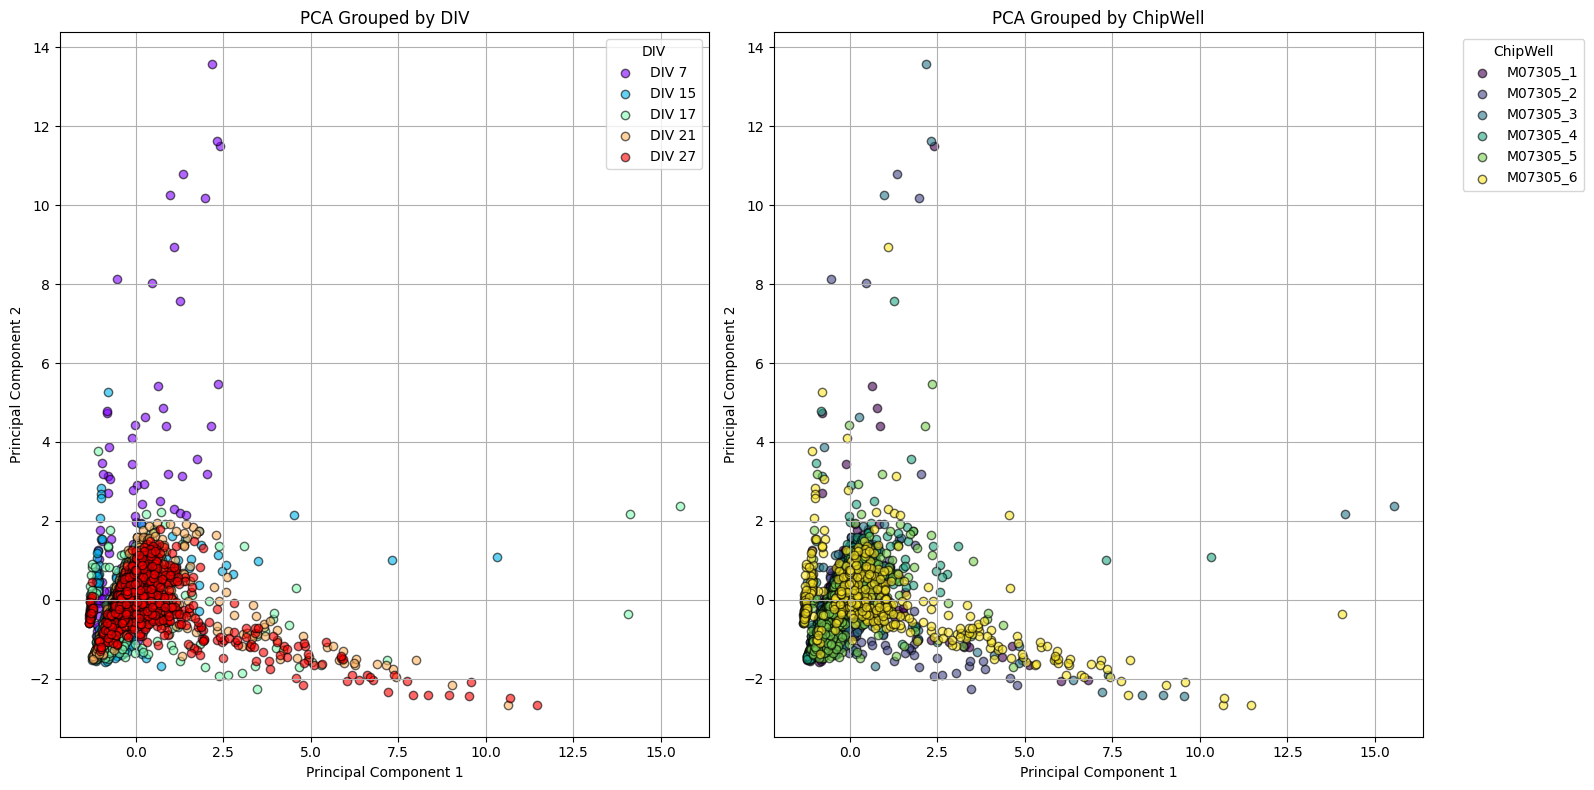

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Assume exploded_df is already defined and contains:
# 'SpikesPerBurst', 'BurstPeak', 'BurstDuration', 'TTNB', 'DIV', 'ChipWell'
# -------------------------------

# 1. Extract the features and convert to a NumPy array.
features = ['SpikesPerBurst', 'BurstPeak', 'BurstDuration', 'TTNB']
X = exploded_df[features].values

# 2. Standardize the features.
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 3. Perform PCA to reduce to 2 dimensions.
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# 4. Combine the PCA results with the metadata.
# Include both 'DIV' and 'ChipWell' columns.
finalDf = pd.concat([principalDf, exploded_df[['DIV', 'ChipWell']].reset_index(drop=True)], axis=1)

# Optional: Print out how much variance is explained by PC1 and PC2.
print("Explained Variance Ratio (PC1, PC2):", pca.explained_variance_ratio_)

# 5. Prepare colors for each unique group.
# For DIV:
unique_divs = finalDf['DIV'].unique()
colors_div = plt.cm.rainbow(np.linspace(0, 1, len(unique_divs)))

# For ChipWell:
unique_chipwells = finalDf['ChipWell'].unique()
colors_chip = plt.cm.viridis(np.linspace(0, 1, len(unique_chipwells)))

# 6. Create subplots for two scatter plots.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Color by DIV.
for div, color in zip(unique_divs, colors_div):
    subset = finalDf[finalDf['DIV'] == div]
    ax1.scatter(subset['PC1'], subset['PC2'],
                color=color, label=f'DIV {div}',
                alpha=0.6, edgecolor='k')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('PCA Grouped by DIV')
ax1.legend(title="DIV")
ax1.grid(True)

# Plot 2: Color by ChipWell.
for chip, color in zip(unique_chipwells, colors_chip):
    subset = finalDf[finalDf['ChipWell'] == chip]
    ax2.scatter(subset['PC1'], subset['PC2'],
                color=color, label=chip,
                alpha=0.6, edgecolor='k')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_title('PCA Grouped by ChipWell')
# Placing the legend outside the plot for clarity.
ax2.legend(title="ChipWell", bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [23]:
print(pca.__dict__.keys())

dict_keys(['n_components', 'copy', 'whiten', 'svd_solver', 'tol', 'iterated_power', 'n_oversamples', 'power_iteration_normalizer', 'random_state', 'n_features_in_', '_fit_svd_solver', 'mean_', 'n_samples_', 'components_', 'n_components_', 'explained_variance_', 'explained_variance_ratio_', 'singular_values_', 'noise_variance_'])


In [13]:
print(principalComponents)
principalComponents.shape

[[-1.03105464 -1.04167691]
 [ 0.62252608  5.40669722]
 [-0.80479961  2.69868215]
 ...
 [-0.40337592 -0.57705721]
 [ 5.85409166 -1.43298441]
 [ 3.15963143 -0.71752929]]


(2731, 2)

Original data shape (observations x features): (2731, 4)
Explained Variance Ratio: [0.48317383 0.28322447]


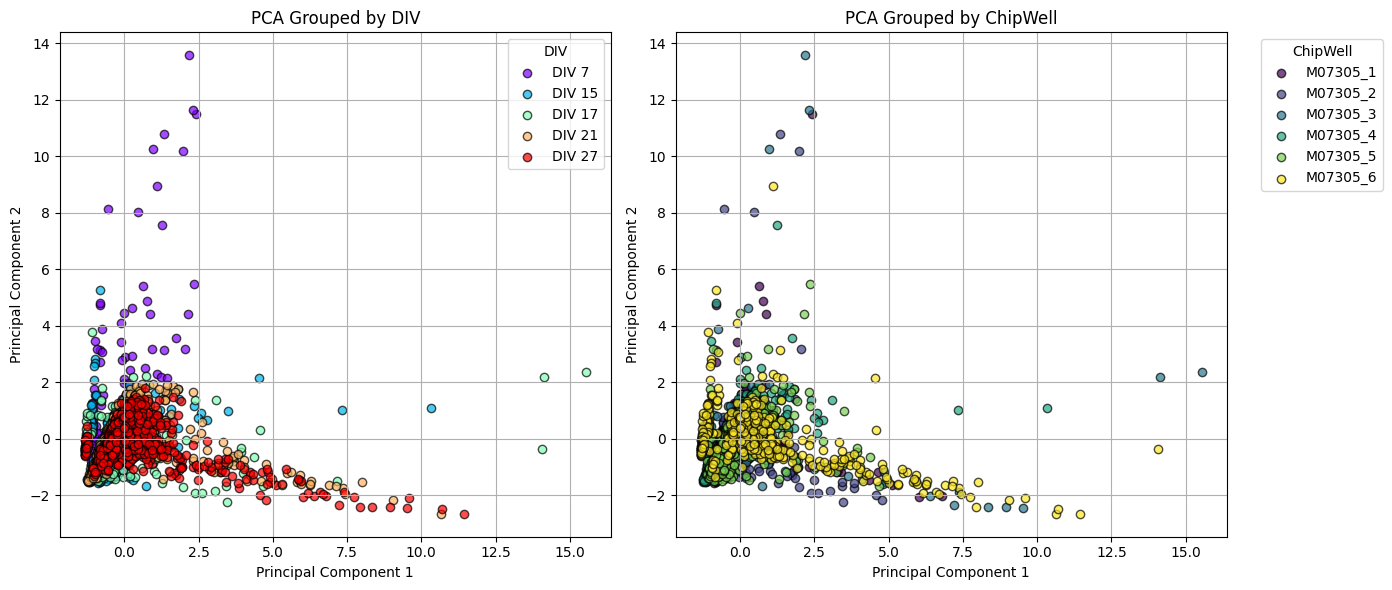

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------------
# Assume exploded_df is already defined and contains:
# 'SpikesPerBurst', 'BurstPeak', 'BurstDuration', 'TTNB', 'DIV', 'ChipWell'
# ----------------------------------------------------------------

# 1. Extract the features from exploded_df.
features = ['SpikesPerBurst', 'BurstPeak', 'BurstDuration', 'TTNB']
X = exploded_df[features].values
print("Original data shape (observations x features):", X.shape)
# For PCA, each row should represent one burst (observation) and each column a feature.

# 2. Standardize the features.
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 3. Run PCA to reduce the data to 2 principal components.
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# 4. Create a DataFrame that includes the two principal components
#    and the metadata columns ('DIV' and 'ChipWell') for grouping.
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
pca_df = pd.concat([pca_df, exploded_df[['DIV', 'ChipWell']].reset_index(drop=True)], axis=1)

# 5. Visualize the PCA results grouped by DIV and by ChipWell.
plt.figure(figsize=(14, 6))

# ------------------------------
# Plot 1: Color by DIV
# ------------------------------
plt.subplot(1, 2, 1)
unique_divs = pca_df['DIV'].unique()
colors_div = plt.cm.rainbow(np.linspace(0, 1, len(unique_divs)))

for div, color in zip(unique_divs, colors_div):
    subset = pca_df[pca_df['DIV'] == div]
    plt.scatter(subset['PC1'], subset['PC2'],
                color=color, label=f'DIV {div}',
                alpha=0.7, edgecolor='k')
plt.title("PCA Grouped by DIV")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="DIV")
plt.grid(True)

# ------------------------------
# Plot 2: Color by ChipWell
# ------------------------------
plt.subplot(1, 2, 2)
unique_chipwells = pca_df['ChipWell'].unique()
colors_chip = plt.cm.viridis(np.linspace(0, 1, len(unique_chipwells)))

for chip, color in zip(unique_chipwells, colors_chip):
    subset = pca_df[pca_df['ChipWell'] == chip]
    plt.scatter(subset['PC1'], subset['PC2'],
                color=color, label=chip,
                alpha=0.7, edgecolor='k')
plt.title("PCA Grouped by ChipWell")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="ChipWell", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
# pca.components_ is V^T (shape: [n_components, n_features])
VT = pca.components_
print("V^T (Principal Axes):")
print(VT)

# pca.singular_values_ gives the singular values S
S = pca.singular_values_
print("\nSingular Values S:")
print(S)

# Compute the left singular vectors U.
# Since pca.transform(X) = U * S, we recover U by dividing each column of the transformed data by the singular value.
# Make sure to handle broadcasting correctly.
U = principalComponents / S  # Each column divided by its corresponding singular value
print("\nLeft Singular Vectors U:")
print(U)

V^T (Principal Axes):
[[ 0.70928292  0.21393022  0.67066955  0.03679629]
 [-0.00258604  0.68294824 -0.25271393  0.68535442]]

Singular Values S:
[72.65115918 55.62323331]

Left Singular Vectors U:
[[-0.01419185 -0.01872737]
 [ 0.0085687   0.09720214]
 [-0.01107759  0.04851718]
 ...
 [-0.00555223 -0.01037439]
 [ 0.08057809 -0.02576234]
 [ 0.04349045 -0.01289981]]


----- LDA Classifier for DIV -----
Accuracy (DIV): 0.375609756097561




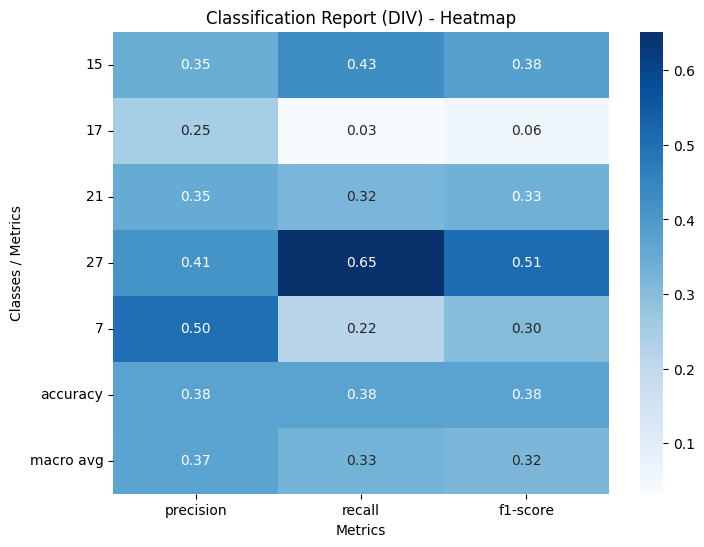

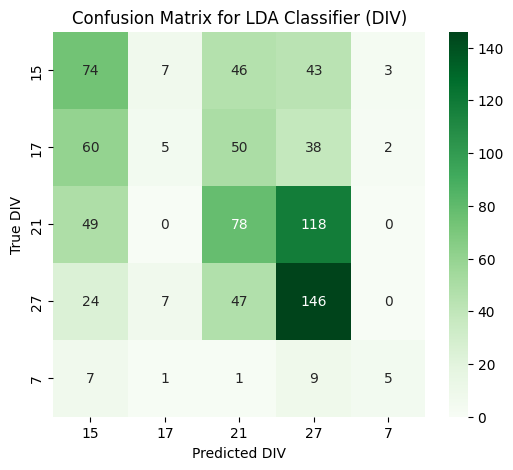

----- LDA Classifier for ChipWell -----
Accuracy (ChipWell): 0.2804878048780488




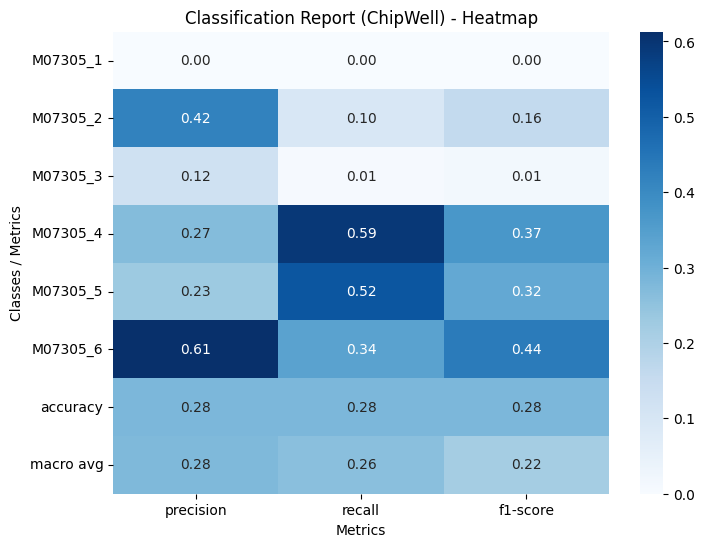

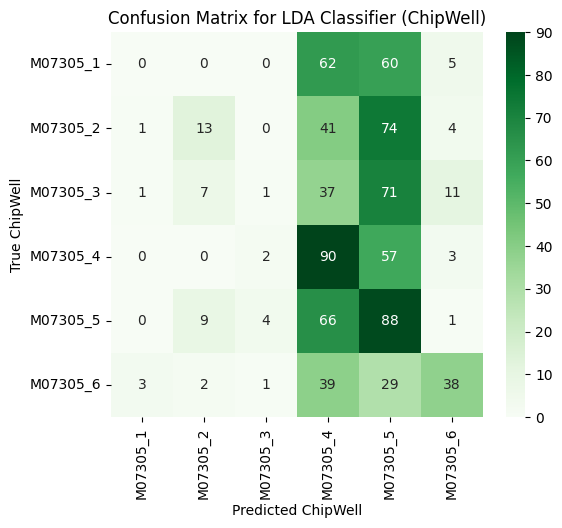

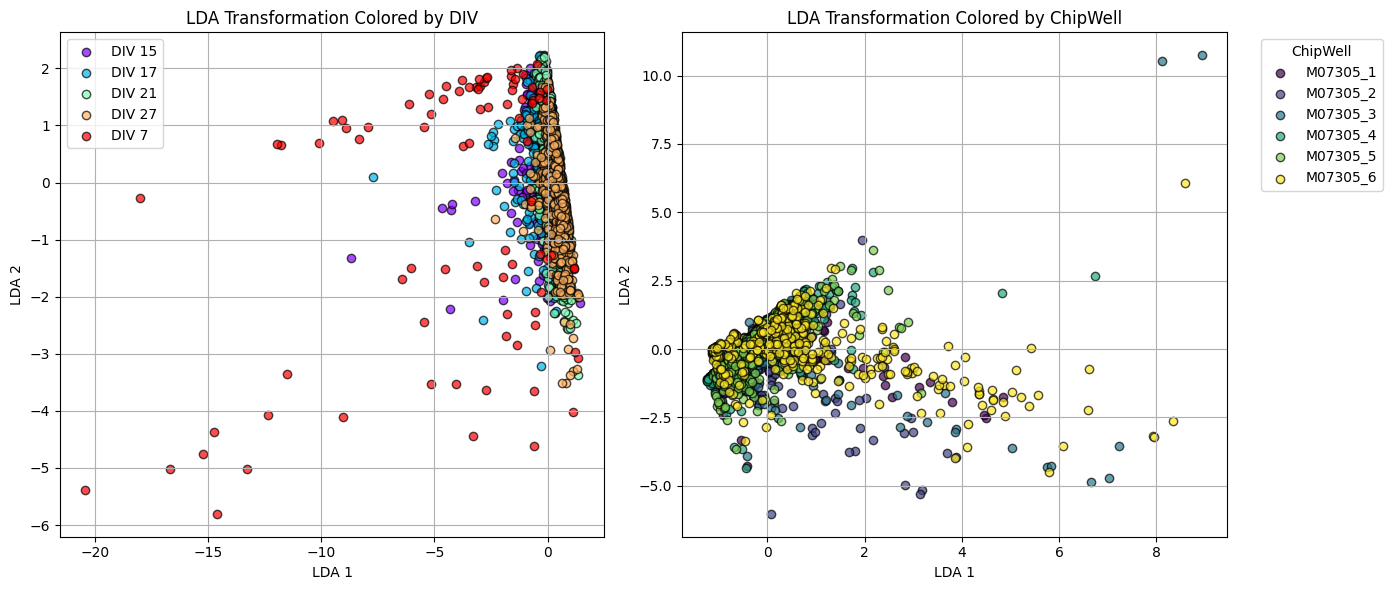

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --------------------------------------------------------------------
# Assume exploded_df is already defined and contains:
# 'SpikesPerBurst', 'BurstPeak', 'BurstDuration', 'TTNB', 'DIV', 'ChipWell'
# --------------------------------------------------------------------

# 1. Define the feature matrix and the target variables.
features = ['SpikesPerBurst', 'BurstPeak', 'BurstDuration', 'TTNB']
X = exploded_df[features].values

# Targets: one for DIV and one for ChipWell
y_div = exploded_df['DIV'].values
y_chip = exploded_df['ChipWell'].values

# 2. Standardize the feature matrix.
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 3. Split the data into training and test sets.
# For the DIV classifier:
X_train_div, X_test_div, y_train_div, y_test_div = train_test_split(X_std, y_div, test_size=0.3, random_state=42)

# For the ChipWell classifier:
X_train_chip, X_test_chip, y_train_chip, y_test_chip = train_test_split(X_std, y_chip, test_size=0.3, random_state=42)

# 4. Build and train the LDA classifier for DIV.
lda_div = LDA()
lda_div.fit(X_train_div, y_train_div)
y_pred_div = lda_div.predict(X_test_div)

print("----- LDA Classifier for DIV -----")
print("Accuracy (DIV):", accuracy_score(y_test_div, y_pred_div))
print("\n")

# 5. Generate and visualize the classification report for DIV.
report_div = classification_report(y_test_div, y_pred_div, output_dict=True)
report_div_df = pd.DataFrame(report_div).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_div_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title("Classification Report (DIV) - Heatmap")
plt.ylabel("Classes / Metrics")
plt.xlabel("Metrics")
plt.show()

# 6. Visualize the confusion matrix for DIV.
cm_div = confusion_matrix(y_test_div, y_pred_div)
labels_div = np.unique(y_test_div)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_div, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels_div, yticklabels=labels_div)
plt.title("Confusion Matrix for LDA Classifier (DIV)")
plt.xlabel("Predicted DIV")
plt.ylabel("True DIV")
plt.show()


# 7. Build and train the LDA classifier for ChipWell.
lda_chip = LDA()
lda_chip.fit(X_train_chip, y_train_chip)
y_pred_chip = lda_chip.predict(X_test_chip)

print("----- LDA Classifier for ChipWell -----")
print("Accuracy (ChipWell):", accuracy_score(y_test_chip, y_pred_chip))
print("\n")

# Generate and visualize the classification report for ChipWell.
report_chip = classification_report(y_test_chip, y_pred_chip, output_dict=True)
report_chip_df = pd.DataFrame(report_chip).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_chip_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title("Classification Report (ChipWell) - Heatmap")
plt.ylabel("Classes / Metrics")
plt.xlabel("Metrics")
plt.show()

# Visualize the confusion matrix for ChipWell.
cm_chip = confusion_matrix(y_test_chip, y_pred_chip)
labels_chip = np.unique(y_test_chip)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_chip, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels_chip, yticklabels=labels_chip)
plt.title("Confusion Matrix for LDA Classifier (ChipWell)")
plt.xlabel("Predicted ChipWell")
plt.ylabel("True ChipWell")
plt.show()


# 8. (Optional) Visualize the LDA transformation.
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Visualization for DIV classifier
X_lda_div = lda_div.transform(X_std)
unique_divs = np.unique(y_div)
colors_div = plt.cm.rainbow(np.linspace(0, 1, len(unique_divs)))
for label, color in zip(unique_divs, colors_div):
    idx = np.where(y_div == label)
    axes[0].scatter(X_lda_div[idx, 0], 
                    X_lda_div[idx, 1] if X_lda_div.shape[1] > 1 else np.zeros(len(idx[0])),
                    color=color, alpha=0.7, label=f'DIV {label}', edgecolor='k')
axes[0].set_title('LDA Transformation Colored by DIV')
axes[0].set_xlabel('LDA 1')
axes[0].set_ylabel('LDA 2' if X_lda_div.shape[1] > 1 else '')
axes[0].legend()
axes[0].grid(True)

# Visualization for ChipWell classifier
X_lda_chip = lda_chip.transform(X_std)
unique_chip = np.unique(y_chip)
colors_chip = plt.cm.viridis(np.linspace(0, 1, len(unique_chip)))
for label, color in zip(unique_chip, colors_chip):
    idx = np.where(y_chip == label)
    axes[1].scatter(X_lda_chip[idx, 0], 
                    X_lda_chip[idx, 1] if X_lda_chip.shape[1] > 1 else np.zeros(len(idx[0])),
                    color=color, alpha=0.7, label=label, edgecolor='k')
axes[1].set_title('LDA Transformation Colored by ChipWell')
axes[1].set_xlabel('LDA 1')
axes[1].set_ylabel('LDA 2' if X_lda_chip.shape[1] > 1 else '')
axes[1].legend(title="ChipWell", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Load data
data_frame= pd.read_csv('/mnt/disk15tb/paula/Main_DA_Projects/data_analysis_output/Primary Neurons/FolicAcid_T2_Feb9/Network_outputs/Compiled_Networks.csv')  # Ensure to change the path as needed
data_frame.columns


Index(['Run_ID', 'DIV', 'Well', 'NeuronType', 'Time', 'Chip_ID', 'mean_IBI',
       'cov_IBI', 'mean_Burst_Peak', 'cov_Burst_Peak', 'Number_Bursts',
       'mean_Spike_per_Burst', 'cov_Spike_per_Burst', 'mean_Burst_Peak_Abs',
       'cov_Burst_Peak_Abs', 'mean_BurstDuration', 'cov_BurstDuration',
       'MeanNetworkISI', 'CoVNetworkISI', 'MeanWithinBurstISI',
       'CoVWithinBurstISI', 'MeanOutsideBurstISI', 'CoVOutsideBurstISI',
       'Fanofactor', 'BurstRate', 'Baseline', 'IBI_List', 'Burst_Peak_List',
       'Abs_Burst_Peak_List', 'Burst_Times_List', 'SpikesPerBurst_List'],
      dtype='object')

In [11]:
from itertools import combinations
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

# Columns to process
columns_to_process = ['Burst_Peak_List', 'Burst_Times_List', 'IBI_List', 'SpikesPerBurst_List','Abs_Burst_Peak_List']

# Step 1: Convert the specified columns into individual lists of floats
temp_df = data_frame.copy()
for column in columns_to_process:
    temp_df[column] = temp_df[column].apply(lambda x: [float(i) for i in x.split(",")])

# Truncate lists to match the shortest length for each row
def truncate_lists(row, columns):
    min_length = min(len(row[col]) for col in columns)
    for col in columns:
        row[col] = row[col][:min_length]
    return row

temp_df = temp_df.apply(truncate_lists, columns=columns_to_process, axis=1)

import pandas as pd

# Create a list to hold the exploded rows
exploded_rows = []

# Loop over each row of your preprocessed temp_df
for idx, row in temp_df.iterrows():
    # Extract the lists
    spikes = row['SpikesPerBurst_List']
    
    burst_peaks = row['Burst_Peak_List']
    burst_times = row['Burst_Times_List']
    ibis = row['IBI_List']
    
    # Convert the single–value columns to strings as needed
    div_str = str(row['DIV'])
    chip_well_str = str(row['Chip_ID']) +"_" +str(row['Well'])
    neuron_type = str(row['NeuronType'])
    
    # The lists have been truncated so that they are all the same length.
    # Zip through the list items and create a new row for each burst.
    for sp, bp, bt, ibi in zip(spikes, burst_peaks, burst_times, ibis):
        exploded_rows.append({
            'SpikesPerBurst': sp,
            'BurstPeak': bp,
            'BurstDuration': bt,
            'TTNB': ibi,
            'DIV': div_str,
            'ChipWell': chip_well_str,
            'NeuronType':neuron_type

        })

# Create a new DataFrame from the exploded rows
exploded_df = pd.DataFrame(exploded_rows)

# Optionally, inspect the first few rows:
print(exploded_df.head())

   SpikesPerBurst  BurstPeak  BurstDuration  TTNB DIV  ChipWell NeuronType
0         19378.0     3.0500            7.8  46.8   6  M07039_1       10FA
1          5401.0     3.8991            1.6  47.4   6  M07039_1       10FA
2          5116.0     3.4034            1.8  24.7   6  M07039_1       10FA
3          5462.0     3.7110            1.6  13.2   6  M07039_1       10FA
4          6987.0     3.2354            2.6  32.5   6  M07039_1       10FA


Explained Variance Ratio (PC1, PC2): [0.45348613 0.29181708]


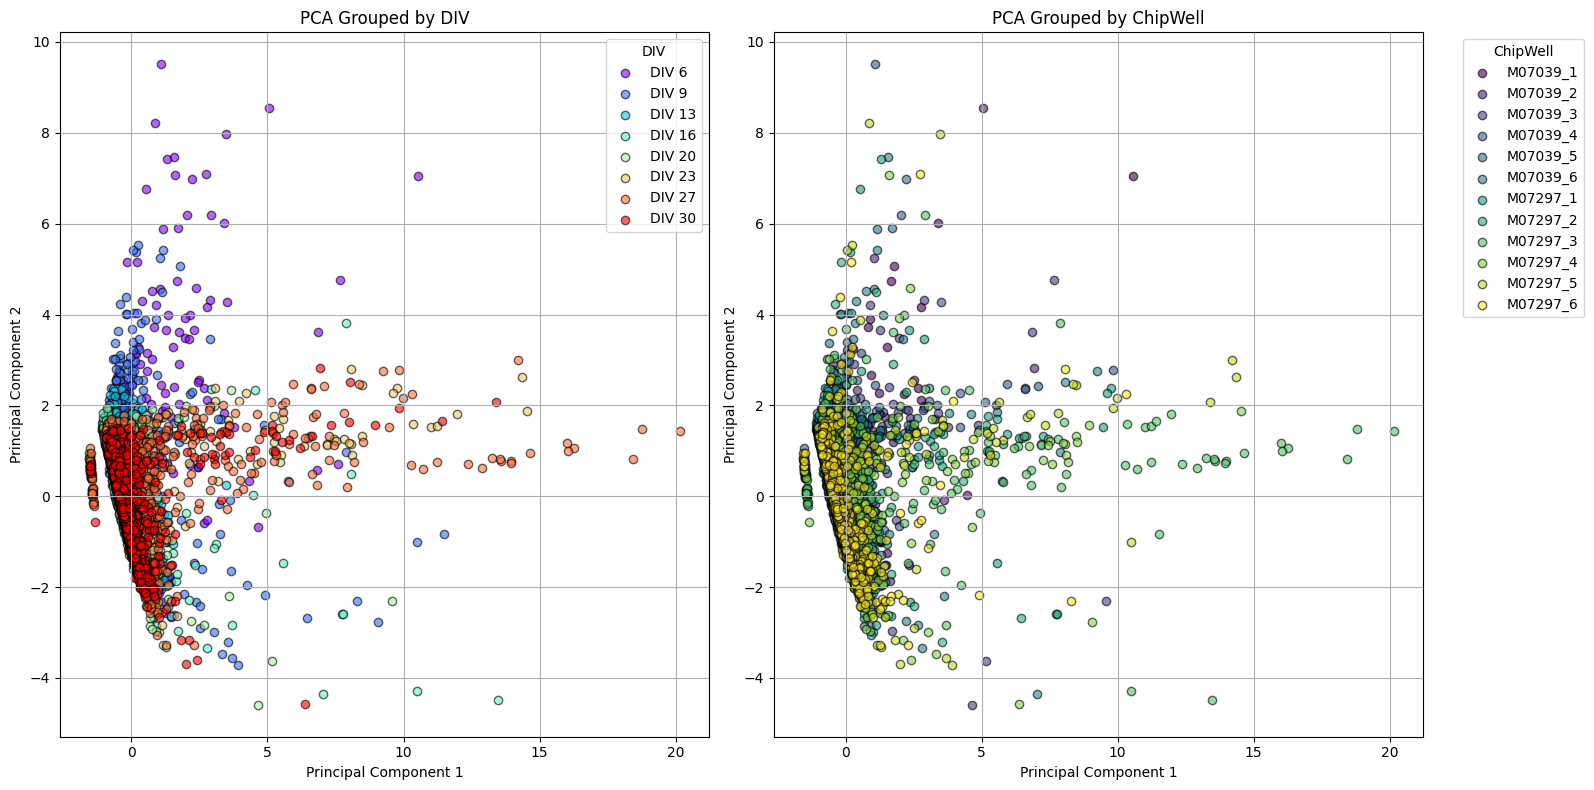

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Assume exploded_df is already defined and contains:
# 'SpikesPerBurst', 'BurstPeak', 'BurstDuration', 'TTNB', 'DIV', 'ChipWell'
# -------------------------------

# 1. Extract the features and convert to a NumPy array.
features = ['SpikesPerBurst', 'BurstPeak', 'BurstDuration', 'TTNB']
X = exploded_df[features].values

# 2. Standardize the features.
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 3. Perform PCA to reduce to 2 dimensions.
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# 4. Combine the PCA results with the metadata.
# Include both 'DIV' and 'ChipWell' columns.
finalDf = pd.concat([principalDf, exploded_df[['DIV', 'ChipWell']].reset_index(drop=True)], axis=1)

# Optional: Print out how much variance is explained by PC1 and PC2.
print("Explained Variance Ratio (PC1, PC2):", pca.explained_variance_ratio_)

# 5. Prepare colors for each unique group.
# For DIV:
unique_divs = finalDf['DIV'].unique()
colors_div = plt.cm.rainbow(np.linspace(0, 1, len(unique_divs)))

# For ChipWell:
unique_chipwells = finalDf['ChipWell'].unique()
colors_chip = plt.cm.viridis(np.linspace(0, 1, len(unique_chipwells)))

# 6. Create subplots for two scatter plots.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Color by DIV.
for div, color in zip(unique_divs, colors_div):
    subset = finalDf[finalDf['DIV'] == div]
    ax1.scatter(subset['PC1'], subset['PC2'],
                color=color, label=f'DIV {div}',
                alpha=0.6, edgecolor='k')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('PCA Grouped by DIV')
ax1.legend(title="DIV")
ax1.grid(True)

# Plot 2: Color by ChipWell.
for chip, color in zip(unique_chipwells, colors_chip):
    subset = finalDf[finalDf['ChipWell'] == chip]
    ax2.scatter(subset['PC1'], subset['PC2'],
                color=color, label=chip,
                alpha=0.6, edgecolor='k')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_title('PCA Grouped by ChipWell')
# Placing the legend outside the plot for clarity.
ax2.legend(title="ChipWell", bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [4]:
# pca.components_ is V^T (shape: [n_components, n_features])
VT = pca.components_
print("V^T (Principal Axes):")
print(VT)

# pca.singular_values_ gives the singular values S
S = pca.singular_values_
print("\nSingular Values S:")
print(S)

# Compute the left singular vectors U.
# Since pca.transform(X) = U * S, we recover U by dividing each column of the transformed data by the singular value.
# Make sure to handle broadcasting correctly.
U = principalComponents / S  # Each column divided by its corresponding singular value
print("\nLeft Singular Vectors U:")
print(U)

V^T (Principal Axes):
[[ 0.71724714  0.11755331  0.68260013  0.07612367]
 [-0.18302965 -0.83878949  0.28957859  0.42317441]]

Singular Values S:
[117.73769135  94.44715201]

Left Singular Vectors U:
[[ 0.08960825  0.07461141]
 [ 0.01414693  0.05022506]
 [ 0.01282349  0.03478639]
 ...
 [-0.00149662 -0.00768138]
 [-0.00091645 -0.00277681]
 [ 0.00090951 -0.00783038]]


----- LDA Classifier for DIV -----
Accuracy (DIV): 0.270824247710423




/home/mmp/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mmp/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mmp/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


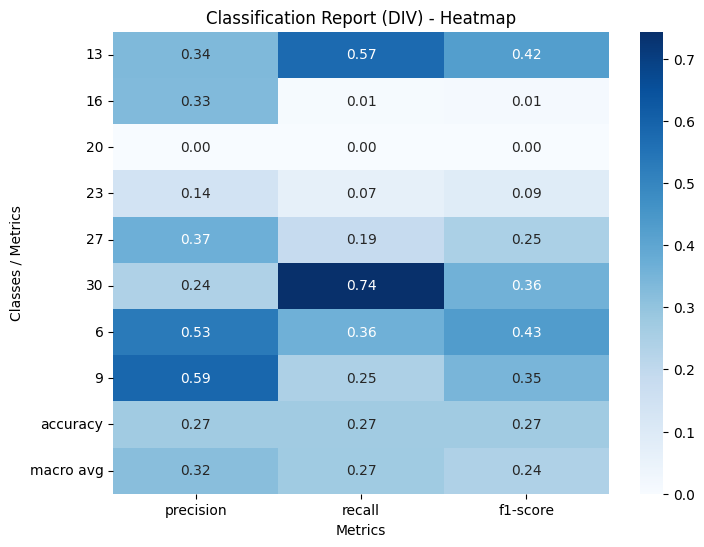

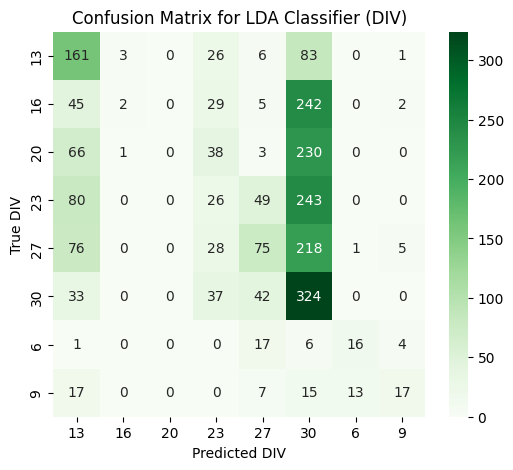

----- LDA Classifier for ChipWell -----
Accuracy (ChipWell): 0.13301351940689055




/home/mmp/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mmp/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mmp/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


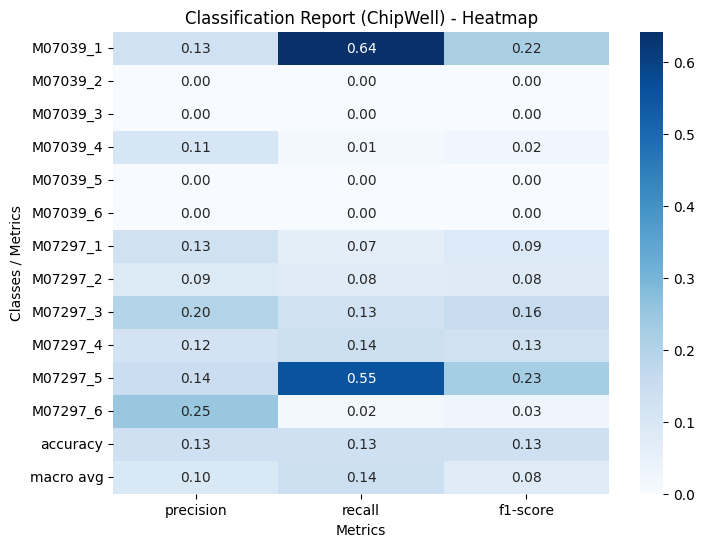

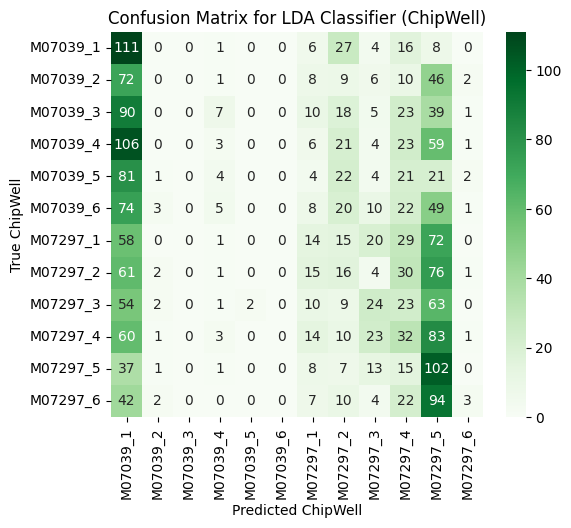

----- LDA Classifier for NeuronType -----
Accuracy (NeuronType): 0.6170955080680331




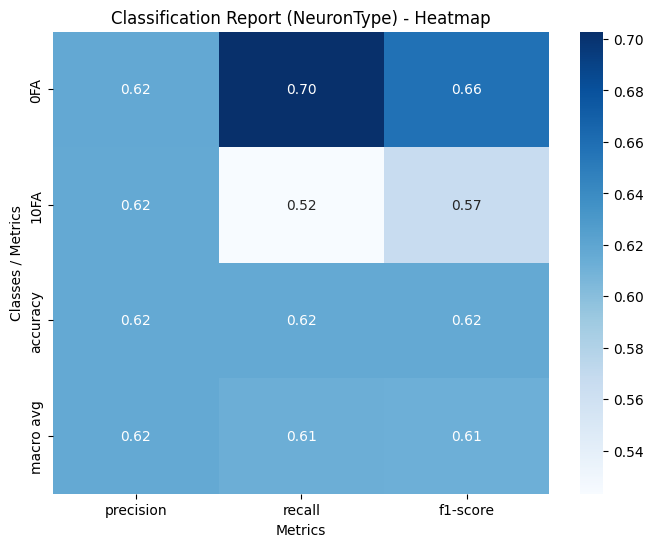

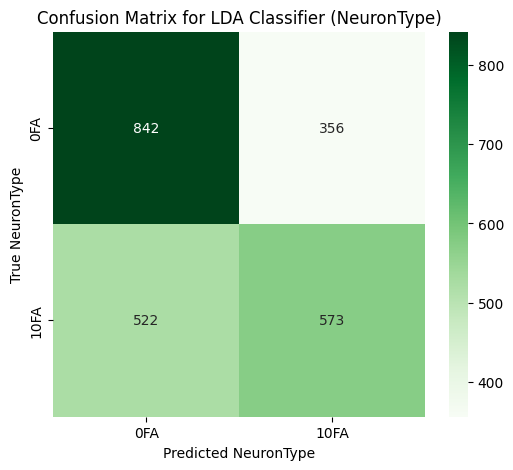

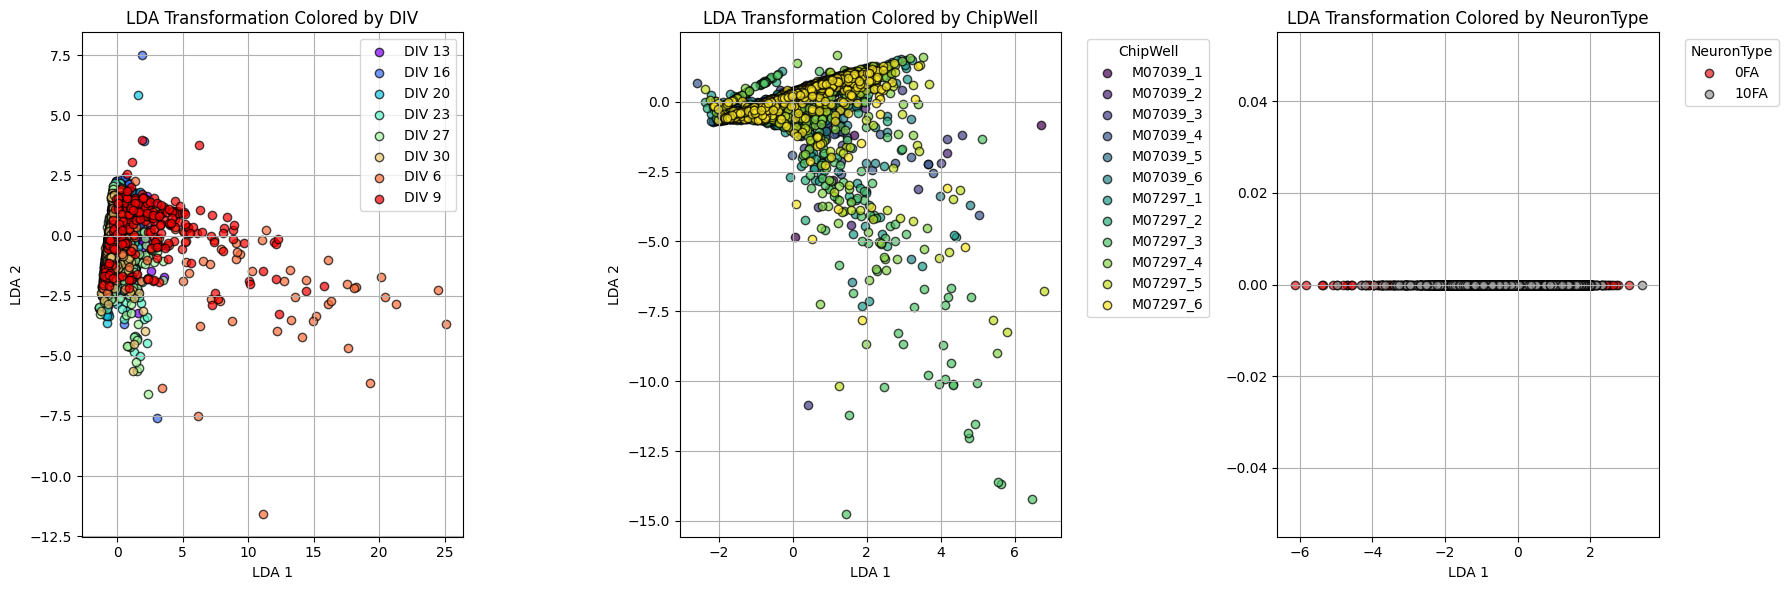

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --------------------------------------------------------------------
# Assume exploded_df is already defined and contains:
# 'SpikesPerBurst', 'BurstPeak', 'BurstDuration', 'TTNB', 'DIV', 'ChipWell', 'NeuronType'
# --------------------------------------------------------------------

# 1. Define the feature matrix and the target variables.
features = ['SpikesPerBurst', 'BurstPeak', 'BurstDuration', 'TTNB']
X = exploded_df[features].values

# Targets: one for DIV, one for ChipWell, and one for NeuronType
y_div = exploded_df['DIV'].values
y_chip = exploded_df['ChipWell'].values
y_neuron = exploded_df['NeuronType'].values

# 2. Standardize the feature matrix.
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 3. Split the data into training and test sets.
# For the DIV classifier:
X_train_div, X_test_div, y_train_div, y_test_div = train_test_split(X_std, y_div, test_size=0.3, random_state=42)
# For the ChipWell classifier:
X_train_chip, X_test_chip, y_train_chip, y_test_chip = train_test_split(X_std, y_chip, test_size=0.3, random_state=42)
# For the NeuronType classifier:
X_train_neuron, X_test_neuron, y_train_neuron, y_test_neuron = train_test_split(X_std, y_neuron, test_size=0.3, random_state=42)

# 4. Build and train the LDA classifier for DIV.
lda_div = LDA()
lda_div.fit(X_train_div, y_train_div)
y_pred_div = lda_div.predict(X_test_div)

print("----- LDA Classifier for DIV -----")
print("Accuracy (DIV):", accuracy_score(y_test_div, y_pred_div))
print("\n")

# 5. Generate and visualize the classification report for DIV.
report_div = classification_report(y_test_div, y_pred_div, output_dict=True)
report_div_df = pd.DataFrame(report_div).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_div_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title("Classification Report (DIV) - Heatmap")
plt.ylabel("Classes / Metrics")
plt.xlabel("Metrics")
plt.show()

# 6. Visualize the confusion matrix for DIV.
cm_div = confusion_matrix(y_test_div, y_pred_div)
labels_div = np.unique(y_test_div)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_div, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels_div, yticklabels=labels_div)
plt.title("Confusion Matrix for LDA Classifier (DIV)")
plt.xlabel("Predicted DIV")
plt.ylabel("True DIV")
plt.show()


# 7. Build and train the LDA classifier for ChipWell.
lda_chip = LDA()
lda_chip.fit(X_train_chip, y_train_chip)
y_pred_chip = lda_chip.predict(X_test_chip)

print("----- LDA Classifier for ChipWell -----")
print("Accuracy (ChipWell):", accuracy_score(y_test_chip, y_pred_chip))
print("\n")

# Generate and visualize the classification report for ChipWell.
report_chip = classification_report(y_test_chip, y_pred_chip, output_dict=True)
report_chip_df = pd.DataFrame(report_chip).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_chip_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title("Classification Report (ChipWell) - Heatmap")
plt.ylabel("Classes / Metrics")
plt.xlabel("Metrics")
plt.show()

# Visualize the confusion matrix for ChipWell.
cm_chip = confusion_matrix(y_test_chip, y_pred_chip)
labels_chip = np.unique(y_test_chip)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_chip, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels_chip, yticklabels=labels_chip)
plt.title("Confusion Matrix for LDA Classifier (ChipWell)")
plt.xlabel("Predicted ChipWell")
plt.ylabel("True ChipWell")
plt.show()


# 8. Build and train the LDA classifier for NeuronType.
lda_neuron = LDA()
lda_neuron.fit(X_train_neuron, y_train_neuron)
y_pred_neuron = lda_neuron.predict(X_test_neuron)

print("----- LDA Classifier for NeuronType -----")
print("Accuracy (NeuronType):", accuracy_score(y_test_neuron, y_pred_neuron))
print("\n")

# Generate and visualize the classification report for NeuronType.
report_neuron = classification_report(y_test_neuron, y_pred_neuron, output_dict=True)
report_neuron_df = pd.DataFrame(report_neuron).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_neuron_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title("Classification Report (NeuronType) - Heatmap")
plt.ylabel("Classes / Metrics")
plt.xlabel("Metrics")
plt.show()

# Visualize the confusion matrix for NeuronType.
cm_neuron = confusion_matrix(y_test_neuron, y_pred_neuron)
labels_neuron = np.unique(y_test_neuron)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_neuron, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels_neuron, yticklabels=labels_neuron)
plt.title("Confusion Matrix for LDA Classifier (NeuronType)")
plt.xlabel("Predicted NeuronType")
plt.ylabel("True NeuronType")
plt.show()


# 9. (Optional) Visualize the LDA transformation.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Visualization for DIV classifier transformation.
X_lda_div = lda_div.transform(X_std)
unique_divs = np.unique(y_div)
colors_div = plt.cm.rainbow(np.linspace(0, 1, len(unique_divs)))
for label, color in zip(unique_divs, colors_div):
    idx = np.where(y_div == label)
    axes[0].scatter(X_lda_div[idx, 0],
                    X_lda_div[idx, 1] if X_lda_div.shape[1] > 1 else np.zeros(len(idx[0])),
                    color=color, alpha=0.7, label=f'DIV {label}', edgecolor='k')
axes[0].set_title('LDA Transformation Colored by DIV')
axes[0].set_xlabel('LDA 1')
axes[0].set_ylabel('LDA 2' if X_lda_div.shape[1] > 1 else '')
axes[0].legend()
axes[0].grid(True)

# Visualization for ChipWell classifier transformation.
X_lda_chip = lda_chip.transform(X_std)
unique_chip = np.unique(y_chip)
colors_chip = plt.cm.viridis(np.linspace(0, 1, len(unique_chip)))
for label, color in zip(unique_chip, colors_chip):
    idx = np.where(y_chip == label)
    axes[1].scatter(X_lda_chip[idx, 0],
                    X_lda_chip[idx, 1] if X_lda_chip.shape[1] > 1 else np.zeros(len(idx[0])),
                    color=color, alpha=0.7, label=label, edgecolor='k')
axes[1].set_title('LDA Transformation Colored by ChipWell')
axes[1].set_xlabel('LDA 1')
axes[1].set_ylabel('LDA 2' if X_lda_chip.shape[1] > 1 else '')
axes[1].legend(title="ChipWell", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)

# Visualization for NeuronType classifier transformation.
X_lda_neuron = lda_neuron.transform(X_std)
unique_neuron = np.unique(y_neuron)
colors_neuron = plt.cm.Set1(np.linspace(0, 1, len(unique_neuron)))
for label, color in zip(unique_neuron, colors_neuron):
    idx = np.where(y_neuron == label)
    axes[2].scatter(X_lda_neuron[idx, 0],
                    X_lda_neuron[idx, 1] if X_lda_neuron.shape[1] > 1 else np.zeros(len(idx[0])),
                    color=color, alpha=0.7, label=label, edgecolor='k')
axes[2].set_title('LDA Transformation Colored by NeuronType')
axes[2].set_xlabel('LDA 1')
axes[2].set_ylabel('LDA 2' if X_lda_neuron.shape[1] > 1 else '')
axes[2].legend(title="NeuronType", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[2].grid(True)

plt.tight_layout()
plt.show()